## ◼제주도 관광지 추천 시스템

- 시스템 동작 과정
  - 키워드 선택
    - 카테고리 선택
      - 세부사항 선택 : 대표 장소, 관광지 수 입력
        - 관광지 : 이미지 선택
        - 음식점 : 이미지 선택 -> CLIP을 활용한 라벨 이용
        - 카페 : 이미지나 자연어 이용하기 어려움
      - 관광지 추천 : 유사도, 평점 등을 활용하여 관광지 추천
  - 최적 경로 탐색 : 추천된 관광지 최적 경로 탐색

In [1]:
# 사용 라이브러리
import json
import requests
import folium
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import set_matplotlib_korean
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm

Korean OK in your Windwos !!!


In [344]:
# 파일 Path 및 주요 키워드
img_home = './data/220122/종합_이미지/'

img_euclidean_path = './data/220124/_image_euclidean_dist.npy'
rest_clip_label = './data/220126/_음식점_CLIP라벨링.xlsx'
jeju_poi_path = './data/220124/_종합_POI_주변관광지_추가.xlsx'

keywords = {'1' : '테마파크',
            '2' : '감성',
            '3' : '오션뷰',
            '4' : '레포츠',
            '5' : '맛집',
            '6' : '체험',
            '7' : '가족여행',
            '8' : '분위기 좋은',
            '9' : '가볼만한 곳'}

categories = {'1' : '관광명소',
              '2' : '음식점',
              '3' : '카페',}

poi_list = ['관광명소', '음식점', '카페']

# 제주도 중심 좌표 (x, y)
jeju_pos = [126.54536611348854, 33.38394921171469]

# 시작 좌표 (x, y) : 제주국제공항
default_pos = [126.49411256317285, 33.50589515795999]

# 기본 컬럼
columns = ['idx', 'keyword', 'address_name', 'category_group_name',
       'category_name', 'id', 'place_name', 'x', 'y', 'rating', 'kind',
       'content', 'adjacent_tour', 'adjacent_rest', 'adjacent_cafe']

### 1. 테마 선택

- 키워드(9개) : '테마파크', '감성', '오션뷰', '레포츠', '맛집', '체험', '가족여행', '분위기 좋은', '가볼만한 곳'
- 카테고리 그룹(3개) : '관광명소', '음식점', '카페'

#### ◽키워드 선택

In [349]:
print('키워드를 선택해주시기 바랍니다. 복수 선택시 공백(space)으로 구분')
print('-'*60)
for key, value in keywords.items():
    print('\t{}. {}'.format(key, value))
print('-'*60)
print('키워드 입력(번호 선택) : ', end ='')
keyword_nums = input().split(' ')
keyword_result = [keywords[key] for key in keyword_nums]
print(keyword_nums, '-', keyword_result)

키워드를 선택해주시기 바랍니다. 복수 선택시 공백(space)으로 구분
------------------------------------------------------------
	1. 테마파크
	2. 감성
	3. 오션뷰
	4. 레포츠
	5. 맛집
	6. 체험
	7. 가족여행
	8. 분위기 좋은
	9. 가볼만한 곳
------------------------------------------------------------
키워드 입력(번호 선택) : ['1', '2', '3'] - ['테마파크', '감성', '오션뷰']


In [350]:
print('키워드를 선택해주시기 바랍니다. 단수 선택')
print('-'*60)
for key, value in categories.items():
    print('\t{}. {}'.format(key, value))
print('-'*60)
print('키워드 입력(번호 선택, 종료시 0) : ', end ='')
category_num = input()
if category_num == '0':
    print('종료') # 종료 문구
else:
    category_result = categories[category_num]
    print(category_num, '-', category_result)

키워드를 선택해주시기 바랍니다. 단수 선택
------------------------------------------------------------
	1. 관광명소
	2. 음식점
	3. 카페
------------------------------------------------------------
키워드 입력(번호 선택, 종료시 0) : 1 - 관광명소


#### ◽코사인 유사도 확인

##### 직선 거리 계산 함수

- 위도, 경도 계산
    - 우리나라 기준 1도 = 88.8km, 1분 = 1.48km, 1초 = 25m
    - 구글의 좌표는 `도` 기준
    - 위도 차이 : ((a.lat - b.lat) * 88.8) km
    - 경도 차이 : ((a.lng - b.lng) * 88.8) km
    - 거리 차이 : (위도 차이 ** 2 + 경도 차이 ** 2) ** (1/2) km

In [351]:
# 좌표간의 직선 거리 계산 함수
# pos1 : (x좌표, y좌표)
# pos2 : (x좌표, y좌표)
def cal_dist(pos1, pos2):
    return (((pos1[1] - pos2[1])*88.8)**2 +((pos1[0] - pos2[0])*88.8)**2)**(1/2)

##### 자연어 코사인 유사도 함수

- 입력값에 대한 코사인 유사도 반환 함수

In [352]:
# content, 입력값의 count_vector matrix 반환 함수
# keyword : 입력받은 키워드 리스트
# category : 입력받은 카테고리 리스트
# content : 장소 정보의 'content' 컬럼
#           - content : keyword + category_group_name
def get_count_mat(keyword, category, content):
    # content를 이용해 count_vector 학습
    count_vect = CountVectorizer(min_df = 0, ngram_range=(1, 2))
    content_mat = count_vect.fit_transform(content)
    input_result = keyword.copy()
    input_result.append(category)
    # count vecter를 위해 각 단어의 공백(space) 삭제
    input_result = [input_str.replace(' ', '') for input_str in input_result]
    # input_result를 이용해 count_vector 생성
    input_mat = count_vect.transform([' '.join(input_result)])

    return input_mat, content_mat


In [353]:
# input_mat 기준 sim_mat의 유사도 결과 반환
# DataFrame의 컬럼으로 추가하기 위해 reshape하여 반환
def get_cosine_sim(input_mat, sim_mat):
    input_sim = cosine_similarity(input_mat, sim_mat)
    return input_sim.reshape(-1, 1)

In [354]:
# content(keyword + category_group_name) 기준 코사인 상위 Top20 반환
# original : 코사인 유사도를 구할 원본 Dataframe
# keywords : 입력받은 keyword 리스트
# category : 코사인 유사도를 구할 카테고리명
def get_cosine_top20(original, keywords, category):
    # 코사인 유사도 획득
    input_mat, content_mat = get_count_mat(keywords, category, original['content'])
    input_sim = get_cosine_sim(input_mat, content_mat)
    # 코사인 유사도 컬럼 추가
    original['input_sim'] = input_sim

    # 유사도 결과 Top 20 반환
    return original.query(f'category_group_name == "{category}"').sort_values('input_sim', ascending=False).iloc[:20, :]

- 장소 정보(원본 데이터) 읽기

In [355]:
past_poi = None
past_pos = default_pos
jeju_poi = pd.read_excel(jeju_poi_path, index_col=False)

In [356]:
jeju_poi.head(1)

,idx,keyword,address_name,category_group_name,category_name,id,place_name,x,y,rating,kind,content,adjacent_tour,adjacent_rest,adjacent_cafe
0,0,테마파크,제주특별자치도 제주시 연동 1320,관광명소,"문화,예술 > 문화시설 > 박물관",26388484,수목원테마파크 아이스뮤지엄,126.488398,33.470777,1.0,제주시,테마파크 관광명소,29,268,138


##### 자연어 코사인 유사도 테스트

In [357]:
cosine_poi = get_cosine_top20(jeju_poi, keyword_result, category_result)
if cosine_poi is not None:
    cosine_poi = cosine_poi.reset_index(drop=True)

In [358]:
print(category_result)
cosine_poi[['id', 'place_name', 'input_sim']]

관광명소


,id,place_name,input_sim
0,26388484,수목원테마파크 아이스뮤지엄,0.577350
1,12520358,제주거울미로 이상한나라의 앨리스,0.577350
2,303901411,파더스가든,0.577350
3,1527411751,다이나믹메이즈 제주도성읍점,0.577350
4,1870273669,신화워터파크,0.577350
5,12665029,금호리조트 제주아쿠아나,0.577350
6,11330871,소인국테마파크,0.577350
7,942616668,뽀로로앤타요테마파크 제주,0.577350
8,9720913,마린파크,0.577350
9,11059651,산방산랜드,0.577350


### 2. 세부 사항 선택 : 대표 선택

#### ◽Top 20 장소 확인

In [359]:
cosine_poi[['place_name', 'content', 'input_sim']]

,place_name,content,input_sim
0,수목원테마파크 아이스뮤지엄,테마파크 관광명소,0.577350
1,제주거울미로 이상한나라의 앨리스,테마파크 관광명소,0.577350
2,파더스가든,테마파크 관광명소,0.577350
3,다이나믹메이즈 제주도성읍점,테마파크 관광명소,0.577350
4,신화워터파크,테마파크 관광명소,0.577350
5,금호리조트 제주아쿠아나,테마파크 관광명소,0.577350
6,소인국테마파크,테마파크 관광명소,0.577350
7,뽀로로앤타요테마파크 제주,테마파크 관광명소,0.577350
8,마린파크,테마파크 관광명소,0.577350
9,산방산랜드,테마파크 관광명소,0.577350


#### ◽대표 장소 선택

- Top 20 중 대표 장소를 선정한다.
- 각 장소의 대표 이미지를 보여주고 장소 선택
- **선택한 장소를 기준으로 다른 장소 추천**

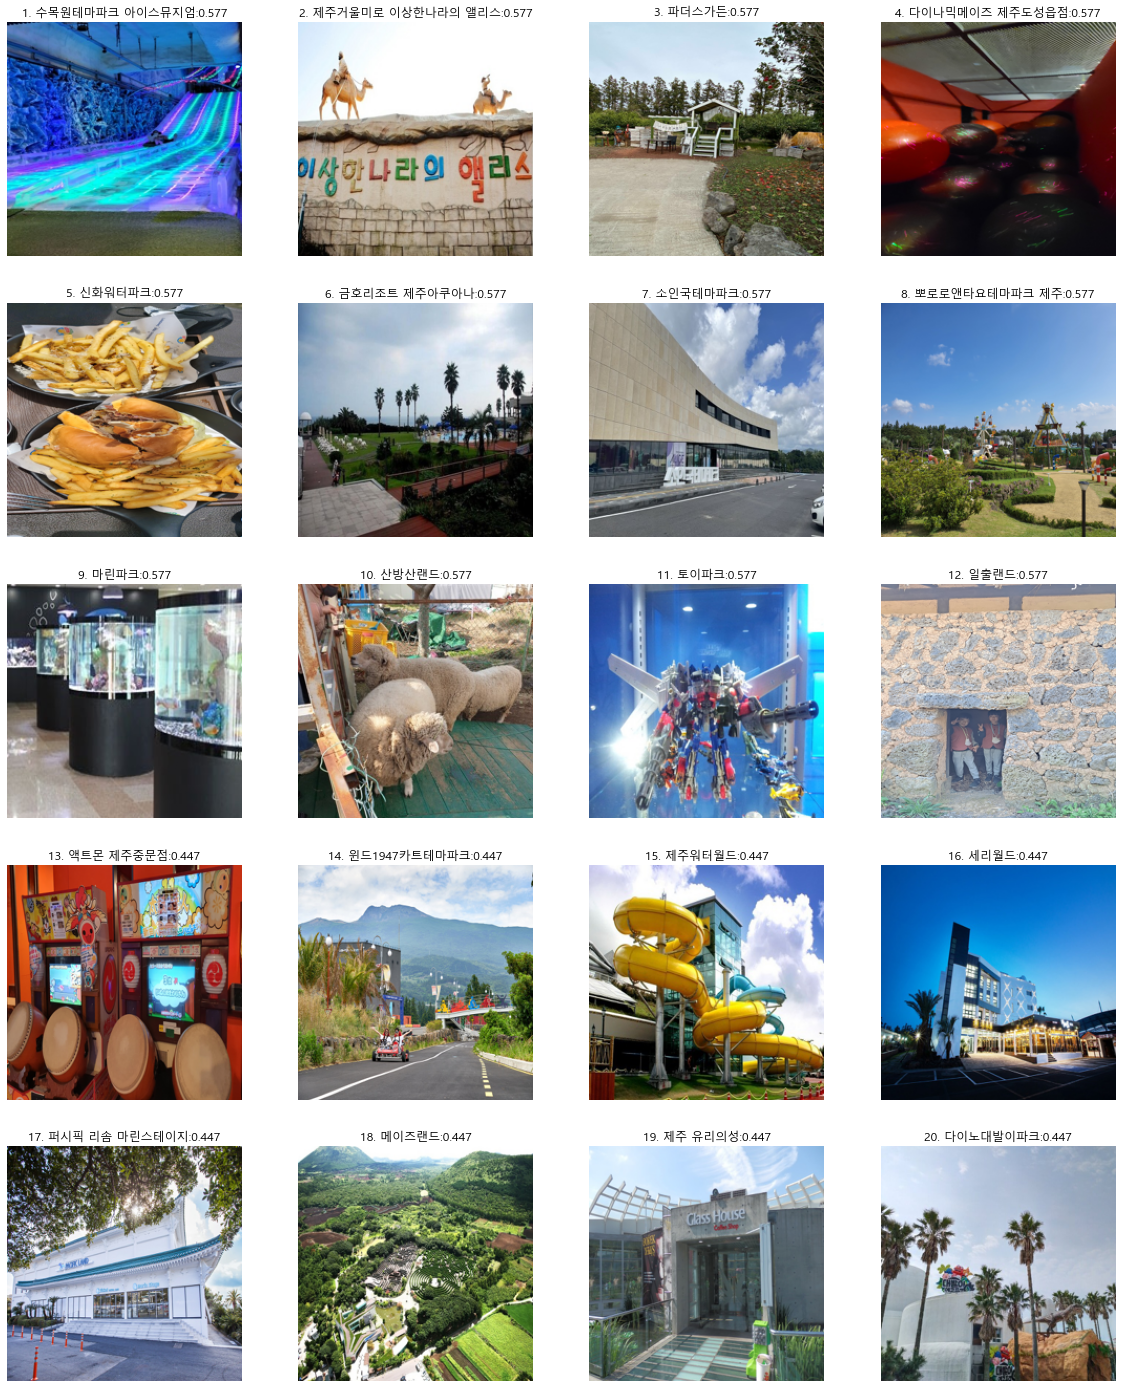

In [360]:
img_info = {}
plt.figure(figsize=(20, 25))
cnt = 1
for idx, row in cosine_poi.iterrows():
    plt.subplot(5, 4, cnt)
    img_path = img_home + row['category_group_name'] + '/'+str(row['id'])+'_'+row['place_name']+'.png'
    img = plt.imread(img_path)
    plt.imshow(img)
    title = str(cnt) + '. ' + row['place_name'] + ':' + str(round(row['input_sim'], 3))
    plt.gca().set_title(title)
    plt.axis(False)
    img_info[str(cnt)] = [row['id'], row['place_name'], round(row['input_sim'], 3)]
    cnt += 1
plt.show()

In [361]:
print('대표 장소를 선택해주시기 바랍니다. 1개만 선택')
print('-'*60)
for key, value in img_info.items():
    print('\t{}. {}'.format(key, value))
print('-'*60)
print('입력(번호 선택) : ', end='')
cosine_num = int(input())
cosine_result = cosine_poi.iloc[cosine_num-1, :]
print(cosine_num, '-', cosine_result['place_name'])

past_poi = cosine_poi[cosine_poi['id'] == img_info[str(cosine_num)][0]].copy()

대표 장소를 선택해주시기 바랍니다. 1개만 선택
------------------------------------------------------------
	1. [26388484, '수목원테마파크 아이스뮤지엄', 0.577]
	2. [12520358, '제주거울미로 이상한나라의 앨리스', 0.577]
	3. [303901411, '파더스가든', 0.577]
	4. [1527411751, '다이나믹메이즈 제주도성읍점', 0.577]
	5. [1870273669, '신화워터파크', 0.577]
	6. [12665029, '금호리조트 제주아쿠아나', 0.577]
	7. [11330871, '소인국테마파크', 0.577]
	8. [942616668, '뽀로로앤타요테마파크 제주', 0.577]
	9. [9720913, '마린파크', 0.577]
	10. [11059651, '산방산랜드', 0.577]
	11. [17630155, '토이파크', 0.577]
	12. [10399499, '일출랜드', 0.577]
	13. [780499262, '액트몬 제주중문점', 0.447]
	14. [820826091, '윈드1947카트테마파크', 0.447]
	15. [17150892, '제주워터월드', 0.447]
	16. [10472331, '세리월드', 0.447]
	17. [10880885, '퍼시픽 리솜 마린스테이지', 0.447]
	18. [13095815, '메이즈랜드', 0.447]
	19. [8064310, '제주 유리의성', 0.447]
	20. [107991673, '다이노대발이파크', 0.447]
------------------------------------------------------------
입력(번호 선택) : 1 - 수목원테마파크 아이스뮤지엄


### 3. 관광지 추천

#### ◽관광지 추천 함수

- 관광명소 추천
- 유클리드 거리, 평점 기준으로 순위 선정

In [362]:
# 관광명소를 추천하는 함수
# 유클리드 거리와 평점을 기준으로 선정
# poi_df : 전체 장소 DataFrame
# select_id : 대표로 선정된 장소의 id
# past_pos : 이전 장소(좌표)
def recommand_tourism(poi_df, select_id, past_pos):
    tour_df = poi_df.query('category_group_name == "관광명소"').reset_index(drop=True)
    img_euclidean_dist = np.load(img_euclidean_path)

    idx = tour_df[tour_df['id'] == select_id].index[0]
    tour_df['img_euclidean_dist'] = img_euclidean_dist[idx]
    # 이전 장소와의 거리가 15km 이하인 경우에서만 선택
    tour_df['dist'] = cal_dist(past_pos, (tour_df['x'], tour_df['y']))
    top20 = tour_df[tour_df['dist'] <= 15].sort_values('img_euclidean_dist', ascending=True).iloc[:20, :]

    return top20[columns].sort_values('rating', ascending=False)


- 음식점 추천
- 주변 음식점(선택한 식당과 동일한 라벨) 중 평점이 높은 경우 추천

In [363]:
# 음식점을 추천하는 함수
# poi_df : 전체 장소 DataFrame
# select_id : 대표로 선정된 장소의 id
# past_pos : 이전 장소(좌표)
def recommand_rest(poi_df, select_item, past_pos):
    rest_df = poi_df.query('category_group_name == "음식점"').reset_index(drop=True)
    food_label = pd.read_excel(rest_clip_label, index_col = False)
    rest_df['food_label'] = food_label['food_label'].copy()
    food = rest_df[rest_df['id'] == select_item[0]]['food_label'][0]
    # 이전 장소와의 거리가 15km 이하인 경우에서만 선택
    rest_df['dist'] = cal_dist(past_pos, (rest_df['x'], rest_df['y']))
    top20 = rest_df[(rest_df['dist'] <= 15) and (rest_df['food_label'] == food)].iloc[:20, :]

    return top20[columns].sort_values('rating', ascending=False)


- 카페 추천
- 주변 카페 중 평점이 높은 경우 추천

In [364]:
# 카페를 추천하는 함수
# poi_df : 전체 장소 DataFrame
# select_id : 대표로 선정된 장소의 id(다른 함수와 동일한 형태를 유지하기 위해 사용)
# past_pos : 이전 장소(좌표)
def recommand_cafe(poi_df, select_item, past_pos):
    cafe_df = poi_df.query('category_group_name == "카페"').reset_index(drop=True)

    # 이전 장소와의 거리가 15km 이하인 경우에서만 선택
    cafe_df['dist'] = cal_dist(past_pos, (cafe_df['x'], cafe_df['y']))
    top20 = cafe_df[cafe_df['dist'] <= 15].sort_values('', ascending=True).iloc[:20, :]

    return top20[columns].sort_values('rating', ascending=False)


- 관광지 추천 함수

In [365]:
# 매개변수 category에 따라 추천 함수 실행 후 결과 반환
# poi_df : 전체 장소 DataFrame
# select_id : 대표로 선정된 장소의 id
# category : 대표로 선정된 장소의 category_group_name
def recommand_site(poi_df, select_id, category, past_pos, included):
    if category == "관광명소":
        temp = recommand_tourism(poi_df, select_id, past_pos)

    elif category == "음식점":
        temp = recommand_rest(poi_df, select_id, past_pos)
    elif category == "카페":
        temp = recommand_cafe(poi_df, select_id, past_pos)
    else:
        print('오류 발생. 유효하지 않은 카테고리 입니다.')
        return None
    # 추천된 관광지 삭제
    included_idx = []
    for p_id in included:
        idx = list(temp[temp['id'] == p_id].index)
        included_idx.extend(idx)
    # 가장 순위가 높은 관광지 추천
    if included_idx:
        return temp.drop(included_idx, axis = 0).iloc[0, :]
    else:
        return temp.iloc[0, :]

#### ◽관광지 추천 함수 테스트

In [366]:
recommand_poi = pd.DataFrame(columns=columns)

- 실제 구현시 반복을 통해 실행할 것이므로 append로 데이터를 추가한다.
- 이전 장소 좌표(past_pos)를 갱신한다.

In [367]:
included = list(recommand_poi['id'])
if category_result == '카페':
    recommand_poi = recommand_poi.append(recommand_site(jeju_poi, None, category_result, past_pos, included))
else:
    recommand_poi = recommand_poi.append(recommand_site(jeju_poi, cosine_result['id'], category_result, past_pos, included))
past_pos = [recommand_poi.iloc[-1]['x'], recommand_poi.iloc[-1]['y']]

In [368]:
recommand_poi[['id', 'place_name', 'rating', 'x', 'y']]

,id,place_name,rating,x,y
23,13725673,수산봉둘레길,5.0,126.381975,33.473535


### 4. 최적 경로 탐색

#### ◽최적 경로 탐색

- 카카오 네비게이션 API 기준 가장 시간이 짧게 걸리는 경우 선택
- 자동차 길찾기
  - 네비게이션 길안내 결과 반환
- 제한 사항 : <a href='https://developers.kakao.com/terms/latest/ko/site-policies#quota' target='_blink'>링크</a>
  - 월간 제공량 : 전체 API 3,000,000건
  - 일간 제공량 : 카카오내비(REST API) 자동차 길찾기 10,000건

- 경로 탐색 실패하는 경우 발생 : **출발지, 도착지 주변에 도로가 없는 경우**
  - 직선 거리 경로도 추가 제공

##### 네비게이션 경로 탐색 함수

In [369]:
# 장소 좌표를 이용해 경로 탐색
# 첫 인덱스 좌표 : 출발지
# 마지막 인덱스 좌표 : 도착지
# 사이의 인덱스 좌표 : 경로
def search_navi_route(routes):
    # REST 키
    rest_api_key = ''
    # 헤더
    headers = {"Authorization" : "KakaoAK {}".format(rest_api_key)}
    origin = routes[0][1]
    destination = routes[-1][1]
    waypoints = [r for p_id, r in routes[1:-1]]
    waypoints = '|'.join(waypoints)
    # 파라미터
    # origin, destination : x, y
    # waypoints : x, y| x, y|...
    url = "https://apis-navi.kakaomobility.com/v1/directions?origin={}&destination={}&waypoints={}".format(origin, destination, waypoints)

    # GET을 이용하여 획득
    res = requests.get(url, headers=headers)
    # Json을 이용하여 해제
    doc = json.loads(res.text)
    
    # 200일 경우 정상
    return res.status_code, doc

In [370]:
def get_navi_vertexes(routes):
    if len(routes) <= 1:
        print('장소를 추가하시기 바랍니다.(최소 장소 개수 : 2개)')
        return None, None, None
    status, doc = search_navi_route(routes)
    # 경로 탐색이 된 경우 (경로, 거리, 시간) 반환
    if status == 200 and doc['routes'][0]['result_code'] == 0:
        vertexes = []
        for section in doc['routes'][0]['sections']:
            for road in section['roads']:
                test_v = road['vertexes']
                for i in range(0, len(test_v), 2):
                    vertexes.append((test_v[i+1], test_v[i]))
        # 경로, 거리, 시간
        return vertexes, doc['routes'][0]['summary']['distance'], doc['routes'][0]['summary']['duration']
    else:
        return None, None, None

##### 네비게이션 경로 탐색 함수 테스트

In [371]:
navi_points = []
for idx, row in recommand_poi.iterrows():
    navi_points.append((row['id'], str(row['x'])+', '+str(row['y'])))

In [372]:
navi_points

[(13725673, '126.381974618862, 33.4735345098889')]

In [373]:
# 경로 테스트를 위해 임의의 위치 추가
navi_points.append((188964570, '126.8735971, 33.43836938'))
navi_points.append((1858538846, '126.8382194, 33.32994996'))

In [374]:
navi_vertexes, navi_dist, navi_duration = get_navi_vertexes(navi_points)

In [375]:
if navi_vertexes is not None:
    print(navi_vertexes[:2])
    print('거리 :', navi_dist)
    print('시간 :',navi_duration)
else:
    print('경로 탐색 실패')

[(33.47353051368058, 126.38199649816875), (33.47430608184507, 126.38201435444134)]
거리 : 67261
시간 : 5736


##### 직선 거리 경로 탐색 함수

In [376]:
# 경로의 직선 거리 계산 함수
# routes : 전체 경로의 좌표((x, y)로 구성된 리스트 형태)
def get_straight_dist(routes):
    if len(routes) <=1 :
        print('장소를 추가하시기 바랍니다.(최소 장소 개수 : 2개)')
        return None
    straight_dist = 0
    for i in range(len(routes) - 1):
        straight_dist += cal_dist(routes[i][1:], routes[i+1][1:])

    # 거리
    return straight_dist

##### 직선 거리 경로 탐색 함수 테스트

In [377]:
straight_points = []
for idx, row in recommand_poi.iterrows():
    straight_points.append((row['id'], float(row['x']), float(row['y'])))

In [378]:
straight_points

[(13725673, 126.381974618862, 33.4735345098889)]

In [379]:
# 경로 테스트를 위해 임의의 위치 추가
straight_points.append((188964570, 126.8735971, 33.43836938))
straight_points.append((1858538846, 126.8382194, 33.32994996))

In [380]:
get_straight_dist(straight_points)

53.89484505517687

In [381]:
straight_vertexes = [(y, x) for p_id, x, y in straight_points]

In [382]:
straight_vertexes

[(33.4735345098889, 126.381974618862),
 (33.43836938, 126.8735971),
 (33.32994996, 126.8382194)]

### 5. 최적 경로 출력

#### ◽최적 경로 표현 : 네비게이션 경로

In [385]:
navi_map = None
if navi_vertexes is not None:
    navi_map = folium.Map(location=[jeju_pos[1], jeju_pos[0]], zoom_start=9)
    for p_id, pos in navi_points:
        x, y = map(float, pos.replace(' ', '').split(','))
        folium.Marker(location=[y, x], popup=p_id).add_to(navi_map)
    folium.PolyLine(navi_vertexes, color='red').add_to(navi_map)
else:
    print("경로 탐색 실패")
navi_map

#### ◽직선 경로 표현

In [384]:
straight_map = folium.Map(location=[jeju_pos[1], jeju_pos[0]], zoom_start=9)
for p_id, x, y in straight_points:    
    folium.Marker(location=[y, x], popup=str(p_id)).add_to(straight_map)
folium.PolyLine(straight_vertexes, color='red').add_to(straight_map)
straight_map